This notebook should also analyze if the vehicle could/couldn't change the lane

In [120]:
import sys
#! does only the last command stand or does it create an order for searching
sys.path.insert(0,'../..')
sys.path.insert(0,'..')

import pathlib

import pandas as pd
import numpy as np
import cv2
import math
import pickle
from time import time, strftime, gmtime

import config

In [121]:
SKIP_FIRST = 3 # How many seconds to skip

VIDEO_FILE = pickle.load(open(f'{config.DATA_PATH}/videopath.p', 'rb'))


SAVE_DETECTIONS = f'{config.DATA_PATH}/detections.p'
save_detections = pickle.load(open(SAVE_DETECTIONS,'rb'))
vid_length = 5*60+3 # Length of video, in seconds
vid_frames = max(save_detections.keys())

OVERWRITE_FPS = vid_frames / vid_length
OVERWRITE_FPS = 0

cap = cv2.VideoCapture(VIDEO_FILE) 
if OVERWRITE_FPS > 0:
    fps = OVERWRITE_FPS
else:
    fps = cap.get(cv2.CAP_PROP_FPS)
    
print ('FPS:', fps)

FPS: 30.0


In [122]:
dfraw = pd.read_csv('./data/lanes_detections.csv', header=None)
dfraw.columns = ['frame', 'lane', 'objectId', 'objectType', 'secMark', 'xLeft', 'xRight', 'yTop', 'yBottom', 'lat', 'lon', 'speed', 'heading', 'elevation'] 
dfraw.speed = dfraw.speed.replace('None', np.nan).astype(float)

if SKIP_FIRST is not None:
    dfraw = dfraw[dfraw.frame >= SKIP_FIRST*fps] # Start processing from 25:10

print (dfraw.shape)
print (dfraw.columns)
dfraw.head()

(29097, 14)
Index(['frame', 'lane', 'objectId', 'objectType', 'secMark', 'xLeft', 'xRight',
       'yTop', 'yBottom', 'lat', 'lon', 'speed', 'heading', 'elevation'],
      dtype='object')


,frame,lane,objectId,objectType,secMark,xLeft,xRight,yTop,yBottom,lat,lon,speed,heading,elevation
4517,90,0,11002838928_1686767011.688996,2,3.0,1445,1508,345,431,45.742685,-122.660459,24.589187,138.955834,40
4518,90,0,11023544784_1686767011.689065,2,3.0,1369,1433,430,503,45.743176,-122.660610,30.685813,183.382137,40
4519,90,0,11023545360_1686767011.6890922,2,3.0,134,255,549,648,45.743761,-122.660348,22.078699,354.418579,40
4520,90,0,11023545936_1686767011.689116,2,3.0,1491,1529,336,392,45.742276,-122.660337,30.383365,183.742109,40
4521,90,0,11023547280_1686767011.689157,2,3.0,653,788,546,630,45.743689,-122.660519,0.951527,127.243980,40


In [123]:
LANES_FROM = (1, 2) # The cars should move over from these lanes
LANES_TO = (4, 5) #the target lanes for the cars from lanes_from (we want to move over to this lane)

FAST_LANES = (1, 4) # Lanes before slow down
SLOW_LANES = (2, 5) # Lanes after slowing down

DIST_FRONT = 15 # Free space in front of the car (on the next lane) [m]
DIST_BEHIND = 20 # Free space behind the car (on the next lane) [m]
CAN_CHANGE_TIME = 9 # minimum time required to change the lane [s]
SPEED_THRESHOLD = 0.8 # if speed_before * SPEED_THRESHOLD > speed_after - the vehicle slowed down

MIN_TIME = 0.2 # Minimum lifetime of the object

## Determining direction
The purpose of this code is to determine the direction of traffic. We need this direction to check if there is enough space in the adjacent lane to move over.


In [124]:
def getObjectIds(dfraw, min_time, fps):
    """
    Returns a list of objects that were at lanes for at least min_time seconds
    Arguments:
        dfraw    - the input dataframe
        min_time - minimum time to be considered
        fps      - fps of the analyzed video
    Returns:
        objectIds - list of ids of objects there were present detected at
                    lanes for at least min_time seconds
    
    """
    df = dfraw.copy()
    df = df.groupby(['objectId', 'lane']).agg({
        'frame' : [np.min, np.max],
    })
    df.columns = ['frame_start', 'frame_end']
    df = df.reset_index()
    df['object_time'] = df.frame_end - df.frame_start
    df = df[df.object_time >= min_time * fps] # Must be detected for at least min_time seconds
    return list (df.objectId)

def normalizeVector(point, vector):
    """
    Normalizes vector to 1 meter length
    Arguments:
        point  - pd.Series that contains lat and lon attributes.
                 Starting point. Can be any point from the examined lane
        vector - pd.Series that contains lat and lon attributes of the
                 vector to be normalized.
    Returns:
        (lat, lon) - normalized vector (pd.Series), parallel to the input 
                     vector, but with the length equal to 1 meter
    """

    degrees_to_radians = math.pi / 180.0

    # phi = 90 - latitude
    phi1 = (90.0 - point.lat) * degrees_to_radians
    phi2 = (90.0 - vector.lat) * degrees_to_radians

    # theta = longitude
    theta1 = point.lon * degrees_to_radians
    theta2 = vector.lon * degrees_to_radians

    cos = (math.sin(phi1) * math.sin(phi2) * math.cos(theta1 - theta2) +
       math.cos(phi1) * math.cos(phi2))

    cos = max(-1, min(1, cos)) # in case of numerical problems

    vec_length = 6731000 * math.acos(cos) # mutliplied by earth radius in meters

    return vector / vec_length


def lineEquation(point, vector):
    """
    Normalizes returns equation of the line given the vector and the starting point
    Arguments:
        point  - pd.Series that contains lat and lon attributes.
                 Starting point. Can be any point from the examined lane
        vector - pd.Series that contains lat and lon attributes 
        
    Returns:
        (a, b, c) - parameters for a * lon + b * lat + c equation. 
    """             
    if vector['lon'] == 0:
        return 1, 0, - point['lon']
    
    x1, y1 = point['lon'], point['lat']
    x2, y2 = point['lon'] + vector['lon'], point['lat'] + vector['lat']
    
    a = (y2 - y1) / (x1 - x2)
    b = 1
    c = - y2 - a* x2
    
    return a, b, c

def getDistance(point, line):
    """
    Computes the distance between a point and a line
    Arguments:
        point - pd.Series ot dictionary that contains lat and lon attributes.
        line  - tuple (a, b, c) that represents line equation (ax+b+c = 0) 
    """
    x = point['lon']
    y = point['lat']
    a, b, c = line
    
    dist = np.abs(a*x+b*y+c) / np.sqrt(a**2 + b**2)
    return dist

def isBetween(point, line1, line2):
    """
    Checks if the point is between two lines
    Arguments:
        point - pd.Series ot dictionary that contains lat and lon attributes.
        line1 - tuple (a, b, c) that represents line equation (ax+b+c = 0) 
        line2 - tuple (a, b, c) that represents line equation (ax+b+c = 0) 
    """
    a, b, c1 = line1
    c2 = line2[-1]
    
    d = np.abs(c1-c2) / np.sqrt(a**2 + b**2)
    return np.abs(getDistance(point, line1) + getDistance(point, line2) - d) < 1e-9 

def isAnyBetween(df, line1, line2):
    """
    Arguments:
        df    - a snippet of dfraw. All the points from this dataframe will be tested
        line1 - tuple (a, b, c) that represents line equation (ax+b+c = 0) 
        line2 - tuple (a, b, c) that represents line equation (ax+b+c = 0) 
    """
    for idx, row in df.iterrows():
        if isBetween(row, line1, line2):
            return True
    return False

def getVectors(dfraw, lanes_from, objectIds):
    """
    Returns vectors parallel and perpendicular to the direction of traffic
    Arguments:
        dfraw       - the input dataframe
        lanes_from   - lane(s) to be considered (int or tuple)
        objectIds - list of ids of objects to be considered
    Returns:
        Tuple of vectors. Each vector is a pd.Series with lat and lon attribuces.
        vector     - a vector parallel to the trafic direction
        vectorNorm - same as vector but normalized (1 meter long)
        vectorPerp - vector perpendicular to the first vector
    """

    if isinstance(lanes_from, int):
        lanes_from = (lanes_from, )

    
    tmp = dfraw[dfraw.lane.isin(lanes_from)]
    tmp = tmp[tmp.objectId.isin(objectIds)]
    dir_start = tmp.loc[tmp.groupby('objectId').agg({'frame' : 'idxmin'}).frame][['objectId', 'frame', 'lat', 'lon']]
    dir_start.columns = ['objectId', 'frame_start', 'lat_start', 'lon_start']
    dir_start.head()

    dir_end = tmp.loc[tmp.groupby('objectId').agg({'frame' : 'idxmax'}).frame][['objectId', 'frame', 'lat', 'lon']]
    dir_end.columns = ['objectId', 'frame_end', 'lat_end', 'lon_end']
    dir_end.head()
    df_direction = dir_start.merge(dir_end, on='objectId')
    df_direction['lon'] = df_direction.lon_end - df_direction.lon_start
    df_direction['lat'] = df_direction.lat_end - df_direction.lat_start
    vector = df_direction[['lat', 'lon']].sum()
    vectorPerp = vector.copy()
    vectorPerp.lon = -vector.lat
    vectorPerp.lat = vector.lon
    starting_point = tmp.iloc[0][['lat', 'lon']]
    vectorNorm = normalizeVector(starting_point, vector)   
    return vector, vectorNorm, vectorPerp
    

In [125]:
objectIds = getObjectIds(dfraw, MIN_TIME, fps)
vector, vectorNorm, vectorPerp = getVectors(dfraw, LANES_FROM, objectIds)

print ('Found {} objects.'.format(len(objectIds)))
print ("Vector:", dict(vector))
print ('Normalized vector:', dict(vectorNorm))
print ('Perpendicular vector:', dict(vectorPerp))

Found 386 objects.
Vector: {'lat': 0.0036293551855024475, 'lon': -0.0009234077501645288}
Normalized vector: {'lat': 2.755412544997587e-10, 'lon': -7.01052712921262e-11}
Perpendicular vector: {'lat': -0.0009234077501645288, 'lon': -0.0036293551855024475}


In [126]:
def checkFreeSpace(dfraw, vectorNorm, dist_front, dist_behind, lanes_from, lanes_to):
    """
    Adds column `to_change` to to the dataframe. This column informs us
    for how many frames the car could change the lane.
    Arguments:
        dfraw       - the input dataframe
        vector_norm - normalized vector (1 meter length), parallel to the
                      direction of traffic
        dist_front  - required free space in front of the car [m]
        dist_behind - required space behind the car [m]
        lanes_from  - only the cars from this lane(s) will be tested (int or tuple)
        lanes_to    - the target lane(s) for the cars from lanes_from (int or tuple)
    Returns:
        New dataframe with 'to_change' column added
    """
    
    if isinstance(lanes_from, int):
        lanes_from = (lanes_from, )
        
    if isinstance(lanes_to, int):
        lanes_to = (lanes_to, )
    
    t = time()
    df = dfraw.copy()
    
    vectorPerp = vectorNorm.copy()
    vectorPerp.lon = -vectorNorm.lat
    vectorPerp.lat = vectorNorm.lon 
    
    df['lat_front'] = df.lat + dist_front * vectorNorm.lat
    df['lon_front'] = df.lon + dist_front * vectorNorm.lon

    df['lat_behind'] = df.lat - dist_behind * vectorNorm.lat
    df['lon_behind'] = df.lon - dist_behind * vectorNorm.lon
    df['can_change_time'] = 0 # Time when the car can change lane, [number of frames]
    
    
    frames = sorted(list(df.frame.unique()))
    
    objectDict = {}
    
    for i, frame in enumerate(frames):
        if i %100 == 0:
            sys.stdout.write('Processing frame {}/{}.         \r'.format(i, len(frames)))
        framedf = df[df.frame == frame]
        totestdf = framedf[framedf.lane.isin(lanes_to)]
        for idx, row in framedf[framedf.lane.isin(lanes_from)].iterrows():

            point = {'lon' : row.lon_front, 'lat' : row.lat_front}
            lane_front = lineEquation(point, vector)
            point = {'lon' : row.lon_behind, 'lat' : row.lat_behind}
            lane_behind = lineEquation(point, vectorNorm)
            if isAnyBetween(totestdf, lane_front, lane_behind):
                objectDict[row.objectId] = 0
            elif row.objectId in objectDict:
                objectDict[row.objectId] += 1
            else:
                objectDict[row.objectId] = 1
                
            df.at[idx, 'can_change_time'] = objectDict[row.objectId]
    print ('{} frames processed in {:.1f} seconds. '.format(len(frames), time() - t))
    return df


In [127]:
dfToChange = checkFreeSpace(dfraw, vectorNorm, DIST_FRONT, DIST_BEHIND, LANES_FROM, LANES_TO)
    

812 frames processed in 0.4 seconds. 


In [128]:
dfToChange.can_change_time.describe()

count    29097.000000
mean         1.724920
std         13.321277
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        203.000000
Name: can_change_time, dtype: float64

### Create the basic dataframe for analysis

In [129]:
df = dfToChange.groupby(['objectId', 'lane']).agg({
    'secMark' : 'count',
    'frame' : [np.min, np.max],
    'speed' : np.nanmean,
    'can_change_time' : np.max
})
df.columns = ['nr_frames', 'frame_start', 'frame_end', 'speed_mean', 'can_change_time']
df = df.reset_index()
print (df.shape)
df['time'] = (df.frame_end - df.frame_start) / fps
df = df[df.time >= MIN_TIME] # Must be detected for at least X seconds
df.can_change_time = df.can_change_time / fps
df = df.sort_values('frame_end')
print (df.shape)
df.head(10)

(486, 7)
(386, 8)


,objectId,lane,nr_frames,frame_start,frame_end,speed_mean,can_change_time,time
117,11023616976_1686767011.6893718,6,11,90,100,21.428262,0.0,0.333333
123,11023621008_1686767011.689496,0,14,90,103,39.547453,0.0,0.433333
336,11024432976_1686767055.665707,-1,7,97,103,NaN,0.0,0.200000
108,11023545360_1686767011.6890922,0,16,90,105,23.144169,0.0,0.500000
348,11024530000_1686767057.093951,-1,7,101,107,NaN,0.0,0.200000
289,11024170704_1686767057.749593,-1,7,103,109,NaN,0.0,0.200000
346,11024528080_1686767059.556829,-1,7,109,115,NaN,0.0,0.200000
221,11023842512_1686767059.556803,-1,7,109,115,NaN,0.0,0.200000
135,11023623888_1686767011.689583,6,29,90,118,22.797545,0.0,0.933333
232,11023984592_1686767012.5994189,5,30,90,119,25.577700,0.0,0.966667


In [130]:
laneObjects = {}
for lane in sorted(list(df.lane.unique())):
    laneObjects[lane] = df.objectId[df.lane == lane].unique()
    print ('{} objects found at lane {}'.format(len(laneObjects[lane]), lane))

137 objects found at lane -1
134 objects found at lane 0
4 objects found at lane 1
5 objects found at lane 2
2 objects found at lane 3
36 objects found at lane 4
35 objects found at lane 5
33 objects found at lane 6


In [131]:
def lane_changed(df, laneObjects, lanes_from, lanes_to = None, never_on = None, verbose = False):
    """
    Functions checks if the objects changed lanes
    Arguments:
        df          - dataframe to be analyzed
        laneObjects - dictionary "laneObjects" 
        lanes_from  - starting lanes (int or tuple)
        lanes_to    - destination lanes (int or tuple)
        never_on    - lanes that the object never appeared on 
                      (int, tuple or None)
        verbose     - for debuging purposes
    Returns:
        set of IDs of objects
    """
    if isinstance(lanes_from, int):
        lanes_from = (lanes_from, )
        
    if isinstance(lanes_to, int):
        lanes_to = (lanes_to, )    

    if isinstance(never_on, int):
        never_on = (never_on, )    
        
    dfret = df[df.lane.isin(lanes_from)]
    if verbose:
        print ('{} objects found on lanes {}'.format(len(dfret.objectId.unique()), lanes_from))
               
    if lanes_to is not None:
        objectIds_stacked = [laneObjects[x] for x in lanes_to]
        objectIds = [item for sublist in objectIds_stacked for item in sublist] # Flatten
        dfret = dfret[dfret.objectId.isin(objectIds)]
    if verbose:
        print ('{} objects were also on {}'.format(len(dfret.objectId.unique()), lanes_to))

    if never_on is not None:
        objectIds_stacked = [laneObjects[x] for x in never_on]
        objectIds = [item for sublist in objectIds_stacked for item in sublist] # Flatten
        dfret = dfret[~dfret.objectId.isin(objectIds)]
    if verbose:
        print ('{} objects were also never on {}'.format(len(dfret.objectId.unique()), never_on))
    
    return set(dfret.objectId)

def mergeLanes(df, lanes):
    """
    Functions merges data from selected lanes into one lane.
    Arguments:
        df     - dataframe to be analyzed
        lanes  - starting lanes (int or tuple)
    Returns:    
        merged dataframe. The resutls contains:
        - lane nr. if two or more lanes are merged, the value is replaced by 0
        - the sum of nr_frames
        - the earlierst frame_start
        - the latest frame_end
        - the weighted mean speed (weights base on nr_frames)
        - the maximum can_change time
        - the summary length of object lifespan (time column)
    """
    
    
    if isinstance(lanes, int): # Nothing to merge
        return df
    
    
    dfret = df[df.lane.isin(lanes)].copy()
    if len(dfret) == len(dfret.objectId.unique()): # No merging necessary
        return df
    
    cols = dfret.columns
    
    dfret['speed_sum'] = dfret.speed_mean * dfret.nr_frames
    dfret = dfret.groupby('objectId').agg({
        'lane' : np.sum,
        'nr_frames' : np.sum,
        'frame_start' : np.min,
        'frame_end' : np.max,
        'can_change_time' : np.max,
        'time' : np.sum,
        'speed_sum' : np.sum,
    }).reset_index()
    
    dfret['speed_mean'] = dfret.speed_sum / dfret.nr_frames
    
    dfret = dfret[cols]
    condition = dfret.lane == sum(lanes)
    dfret.loc[condition, 'lane'] = 0
    
    dfret = dfret.append(df[~df.lane.isin(lanes)], ignore_index = True)
    dfret = dfret.sort_values('frame_end')
    return dfret


### Determine the basic actions
- no need to move over
- moved over
- didn't move over

In [132]:
print ('NO NEED to move over')
noNeed = lane_changed(df, laneObjects, lanes_from = LANES_TO, lanes_to = 6, never_on = LANES_FROM, verbose = 1)
print(f'{len(noNeed)} vehicles found initially')
df_noNeed = df[(df.lane.isin(LANES_TO)) & df.objectId.isin(noNeed)  ].copy()
df_noNeed['action'] = 'noNeed'
        
df_noNeed = df_noNeed.groupby('objectId').agg({
    'lane' : min,
    'nr_frames' : sum,
    'frame_start' : min,
    'frame_end' : max,
    'speed_mean' : np.mean,
    'can_change_time' : max,
    'time' : sum,
    'action' : max

}).reset_index()


# Just a quick test
if False:
    for i in range (7):
        print(i,  len(df_noNeed[df_noNeed.time > i]))
        

print (df_noNeed.shape)        
df_noNeed.head()

NO NEED to move over
48 objects found on lanes (4, 5)
26 objects were also on (6,)
23 objects were also never on (1, 2)
23 vehicles found initially
(23, 9)


,objectId,lane,nr_frames,frame_start,frame_end,speed_mean,can_change_time,time,action
0,10794154896_1686767151.553343,5,14,429,476,32.788775,0.0,1.566667,noNeed
1,11002840848_1686767183.964285,4,317,530,854,24.130463,0.0,10.633333,noNeed
2,11003080720_1686767179.0851462,4,85,516,629,23.247307,0.0,3.700000,noNeed
3,11003322128_1686767109.4339058,5,32,283,319,29.395489,0.0,1.200000,noNeed
4,11023533584_1686767099.497387,4,326,372,711,24.544209,0.0,11.166667,noNeed


In [133]:
df_noNeed.can_change_time.describe()

count    23.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: can_change_time, dtype: float64

In [134]:
print ('MOVED OVER')
movedOver = lane_changed(df, laneObjects, lanes_from = LANES_FROM, lanes_to = LANES_TO, verbose = 1)
df_moveOverCheck = mergeLanes(df[df.lane.isin(LANES_FROM)], LANES_FROM)
df_moveOver = df_moveOverCheck[df_moveOverCheck.objectId.isin(movedOver)].copy()
df_moveOver['action'] = 'moveOver'
print (df_moveOver.shape)
df_moveOver.head()

MOVED OVER
9 objects found on lanes (1, 2)
3 objects were also on (4, 5)
3 objects were also never on None
(3, 9)


,objectId,lane,nr_frames,frame_start,frame_end,speed_mean,can_change_time,time,action
291,11024170704_1686767057.749593,1,108,110,226,26.508944,3.600000,3.866667,moveOver
197,11023827664_1686767021.2903192,1,20,222,244,37.887952,0.666667,0.733333,moveOver
264,11024157200_1686767040.9963121,1,99,198,314,28.570508,3.300000,3.866667,moveOver


In [135]:
print ("DIDN'T MOVE OVER")
noMoveOver = lane_changed(df[~df.objectId.isin(movedOver)], laneObjects, \
                          lanes_from = LANES_FROM, lanes_to = 3, never_on = LANES_TO, verbose = 1)
df_noMoveOver = df_moveOverCheck[df_moveOverCheck.objectId.isin(noMoveOver)].copy()
df_noMoveOver['action'] = 'noMoveOver'
print (df_noMoveOver.shape)
df_noMoveOver.head()

DIDN'T MOVE OVER
6 objects found on lanes (1, 2)
1 objects were also on (3,)
1 objects were also never on (4, 5)
(1, 9)


,objectId,lane,nr_frames,frame_start,frame_end,speed_mean,can_change_time,time,action
146,11023627024_1686767011.6896682,2,68,90,157,26.099238,2.266667,2.233333,noMoveOver


In [136]:
df.columns

Index(['objectId', 'lane', 'nr_frames', 'frame_start', 'frame_end',
       'speed_mean', 'can_change_time', 'time'],
      dtype='object')

### Speed analysis
Check if vehicles slowed down. It bases on three parameters:
- FAST_LANES    -   list with the segments of the lanes where the vehicles should drive faster
- SLOW_LANES    -   list with the segments of the lanes where the vehicles should drive slower
- SPEED_THRESHOLD - set above.

**Note: This piece of code my required finetuning of FAST_LANES and SLOW_LANES parameters**

In [137]:
def checkSlow(df, fast_lanes, slow_lanes):
    def extract_and_merge(df, lanes):
        if isinstance(lanes, int):
            lanes = (lanes, )    
        
        dfres = df[df.lane.isin(lanes)]
        dfres = dfres.groupby('objectId').agg({
            'frame_start' : np.min,
            'frame_end' : np.max,
            'speed_mean' : np.mean
        }).reset_index()
        return dfres
    
    df_fast = extract_and_merge(df, fast_lanes)
    df_slow = extract_and_merge(df, slow_lanes)
    
    dfSpeed = df_fast.merge(df_slow, on = 'objectId', how='inner')
    dfSpeed = dfSpeed[['objectId', 'frame_start_x', 'frame_start_y', 'speed_mean_x', 'speed_mean_y']]
    dfSpeed.columns = ['objectId', 'frame_start', 'frame_end', 'speed_before', 'speed_after']

    if False: #version with outer join
        notempty = ~dfSpeed.isna().sum(axis=1).astype(bool)
        dfSpeed['slowed'] = np.nan
        dfSpeed.loc[notempty, 'slowed'] = False
        dfSpeed.loc[notempty & (dfSpeed.speed_before * SPEED_THRESHOLD > dfSpeed.speed_after), 'slowed'] = True
    else: # verson with inner join
        dfSpeed['slowed'] = False
        dfSpeed.loc[dfSpeed.speed_before * SPEED_THRESHOLD > dfSpeed.speed_after, 'slowed'] = True

    return dfSpeed
dfSpeed = checkSlow(df, fast_lanes = FAST_LANES, slow_lanes = SLOW_LANES)
dfSpeed = dfSpeed.sort_values('frame_end')
print (dfSpeed.shape)
dfSpeed.head()

(23, 6)


,objectId,frame_start,frame_end,speed_before,speed_after,slowed
5,11023621584_1686767011.689513,90,198,24.886280,25.666661,False
12,11023831696_1686767018.9255722,141,214,28.183423,32.302760,False
6,11023628176_1686767011.689703,90,256,23.078972,26.646921,False
10,11023827664_1686767021.2903192,95,273,30.158281,30.103203,False
16,11024170704_1686767057.749593,110,290,24.048704,28.754830,False


In [138]:
dfSpeed.slowed.value_counts(dropna=False)

False    23
Name: slowed, dtype: int64

In [139]:


#Merge moveOver and noNeed
dfres = pd.concat([df_moveOver, df_noNeed], ignore_index=True)

# Adding can_change information
df_noMoveOver['can_change'] = df_noMoveOver.can_change_time >= CAN_CHANGE_TIME

# Merge noMoveOver to the main table
dfres['can_change'] = np.nan
dfres = pd.concat([dfres, df_noMoveOver], ignore_index=True)

# Adding slow down information
dfres['slowed'] = np.nan
dfres.loc[dfres.objectId.isin(dfSpeed.objectId[dfSpeed.slowed == True]), 'slowed'] = True
dfres.loc[dfres.objectId.isin(dfSpeed.objectId[dfSpeed.slowed == False]), 'slowed'] = False


dfres = dfres.sort_values('frame_end')
dfres.head(5)

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_47987/2209053971.py:9: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  dfres = pd.concat([dfres, df_noMoveOver], ignore_index=True)


,objectId,lane,nr_frames,frame_start,frame_end,speed_mean,can_change_time,time,action,can_change,slowed
19,11023984592_1686767012.5994189,5,30,90,119,25.577700,0.000000,0.966667,noNeed,NaN,NaN
12,11023624464_1686767011.6896,5,31,90,121,24.779922,0.000000,1.033333,noNeed,NaN,NaN
10,11023622160_1686767011.6895308,5,59,90,148,23.651545,0.000000,1.933333,noNeed,NaN,NaN
26,11023627024_1686767011.6896682,2,68,90,157,26.099238,2.266667,2.233333,noMoveOver,0.0,NaN
11,11023622736_1686767011.689548,5,76,90,165,26.178848,0.000000,2.500000,noNeed,NaN,NaN


In [140]:
print (df_noNeed.shape)
print (df_noMoveOver.shape)
print (df_moveOver.shape)
print (dfres.shape)

(23, 9)
(1, 10)
(3, 9)
(27, 11)


In [141]:
dfres.to_csv('./data/actions.csv', index=False)

### Analyses
You can analyze the results manually here, if you need it

In [142]:
print (dfres.slowed.value_counts(dropna = False))
dfres.groupby('action').agg({'slowed' : lambda x: x.value_counts(dropna = False)})

False    18
NaN       9
Name: slowed, dtype: int64


,slowed
action,
moveOver,3
noMoveOver,1
noNeed,"[15, 8]"


In [143]:
dfres.slowed.value_counts(dropna=False)

False    18
NaN       9
Name: slowed, dtype: int64

In [144]:
dfres.action.value_counts()

noNeed        23
moveOver       3
noMoveOver     1
Name: action, dtype: int64

In [145]:
dfres.action[dfres.frame_end < 2*82*fps].value_counts()

noNeed        23
moveOver       3
noMoveOver     1
Name: action, dtype: int64

In [146]:
dfres.head()

,objectId,lane,nr_frames,frame_start,frame_end,speed_mean,can_change_time,time,action,can_change,slowed
19,11023984592_1686767012.5994189,5,30,90,119,25.577700,0.000000,0.966667,noNeed,NaN,NaN
12,11023624464_1686767011.6896,5,31,90,121,24.779922,0.000000,1.033333,noNeed,NaN,NaN
10,11023622160_1686767011.6895308,5,59,90,148,23.651545,0.000000,1.933333,noNeed,NaN,NaN
26,11023627024_1686767011.6896682,2,68,90,157,26.099238,2.266667,2.233333,noMoveOver,0.0,NaN
11,11023622736_1686767011.689548,5,76,90,165,26.178848,0.000000,2.500000,noNeed,NaN,NaN


In [147]:
t = (dfres.frame_end.max() - dfres.frame_start.min()) / fps / 60
coef = 60 / t
dfres.action.value_counts() * coef

noNeed        3152.284264
moveOver       411.167513
noMoveOver     137.055838
Name: action, dtype: float64

# Video generation
This section generates the video with bounding boxes

In [148]:
import glob
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

from time import time

In [149]:
cap = cv2.VideoCapture(VIDEO_FILE) 
if OVERWRITE_FPS > 0:
    fps = OVERWRITE_FPS
else:
    fps = cap.get(cv2.CAP_PROP_FPS)

video_x = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
video_y = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) 
    
TEXT_SPACE_BOTTOM = 180


current_path = os.getcwd()
folder_name = current_path.split(os.sep)[-1]
print (folder_name)


OUTPUT_FRAMES_PATH = os.path.join(config.DATA_PATH, 'frames')
INPUT_FRAMES_PATH = os.path.join(config.DATA_PATH, 'frames_raw')
print ('Input frame_folder: ', INPUT_FRAMES_PATH)

                                  
pathlib.Path(OUTPUT_FRAMES_PATH).mkdir(parents=True, exist_ok=True)

dfres = pd.read_csv('./data/actions.csv').sort_values('frame_end')
dfres.head(5)

example
Input frame_folder:  ./data/frames_raw


,objectId,lane,nr_frames,frame_start,frame_end,speed_mean,can_change_time,time,action,can_change,slowed
0,11023984592_1686767012.5994189,5,30,90,119,25.577700,0.000000,0.966667,noNeed,NaN,NaN
1,11023624464_1686767011.6896,5,31,90,121,24.779922,0.000000,1.033333,noNeed,NaN,NaN
2,11023622160_1686767011.6895308,5,59,90,148,23.651545,0.000000,1.933333,noNeed,NaN,NaN
3,11023627024_1686767011.6896682,2,68,90,157,26.099238,2.266667,2.233333,noMoveOver,0.0,NaN
4,11023622736_1686767011.689548,5,76,90,165,26.178848,0.000000,2.500000,noNeed,NaN,NaN


In [150]:
class ActionCounter:
    def __init__(self):
        self.reset_counter()
        
    def reset_counter(self):
        self.set_all_counters(0)
    
    def set_all_counters(self, value = 0):
        self.noNeed = value
        self.moveOver = value
        self.noMoveOver = value

        self.canChange = value
        self.canChangeSlow = value
        self.canChangeNoSlow = value

        self.cannotChange = value
        self.cannotChangeSlow = value
        self.cannotChangeNoSlow = value


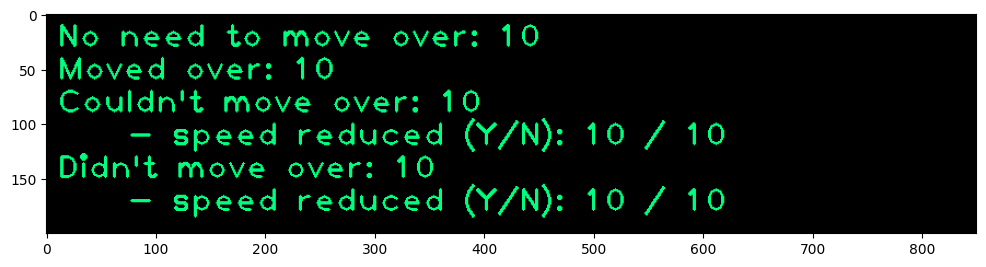

In [151]:
import matplotlib.pyplot as plt
TEXT_SPACE_BOTTOM = 200

def displayImageCounter(c, img_y, img_x, nr_frame, return_int = True):
    """
    Arguments:
        c            - counter (instance of ActionCounter class)
        img_y, img_x - image size
        nr_frame     - number of frame
        return_int   - if True, image pixels are changed into ints (0-255)
    Returns:
        An image with the text 
    """
    
    im = np.zeros((img_y, img_x,3))
    font = cv2.FONT_HERSHEY_PLAIN
    font_scale = 2
    font_thickness = 2
    tmp = dfres[dfres.frame_end == nr_frame]
    if len(tmp) > 0:
        c.noNeed += len(tmp[tmp.action == 'noNeed'])
        c.moveOver += len(tmp[tmp.action == 'moveOver'])
        c.noMoveOver += len(tmp[tmp.action == 'noMoveOver'])
        
        canChangeFilter = (tmp.action == 'noMoveOver') & (tmp.can_change == True)
        c.canChange += len(tmp[canChangeFilter])
        c.canChangeSlow += len(tmp[canChangeFilter & (tmp.slowed == True)])
        c.canChangeNoSlow += len(tmp[canChangeFilter & (tmp.slowed == False)])


        cannotChangeFilter = (tmp.action == 'noMoveOver') & (tmp.can_change == False)
        c.cannotChange += len(tmp[cannotChangeFilter])
        c.cannotChangeSlow += len(tmp[cannotChangeFilter & (tmp.slowed == True)])
        c.cannotChangeNoSlow += len(tmp[cannotChangeFilter & (tmp.slowed == False)])
     
    line_width = 30
    color = (0, 1, 0.5)
    cv2.putText(im, 'No need to move over: {}'.format(c.noNeed),    (10,line_width), 
                font, font_scale, color, font_thickness, cv2.LINE_AA)
    cv2.putText(im, 'Moved over: {}'.format(c.moveOver), (10, 2 * line_width), 
                font, font_scale, color, font_thickness, cv2.LINE_AA)
    
    cv2.putText(im, "Couldn't move over: {}".format(c.cannotChange), (10, 3 * line_width), 
                font, font_scale, color, font_thickness, cv2.LINE_AA)
    cv2.putText(im, "    - speed reduced (Y/N): {} / {}".format(c.cannotChangeSlow, c.cannotChangeNoSlow), 
                (10, 4 * line_width), font, font_scale, color, font_thickness, cv2.LINE_AA)

    cv2.putText(im, "Didn't move over: {}".format(c.canChange), (10, 5 * line_width), 
                font, font_scale, color, font_thickness, cv2.LINE_AA)
    cv2.putText(im, "    - speed reduced (Y/N): {} / {}".format(c.canChangeSlow, c.canChangeNoSlow), 
                (10, 6 * line_width), font, font_scale, color, font_thickness, cv2.LINE_AA)
        
    if return_int:
        im = (255 * im).astype(np.byte)
    return im

test_counter = ActionCounter()
test_counter.set_all_counters(10)
tmp = displayImageCounter(test_counter, TEXT_SPACE_BOTTOM, 850, 40, return_int = False)
plt.figure(figsize = (12, 6))
plt.imshow(tmp)

In [152]:
filenames = glob.glob(os.path.join(INPUT_FRAMES_PATH, '*.jpg'))
filenames.sort()

In [153]:
frame_min = dfres.frame_start.min()
filenames = [filename for filename in filenames if int(filename.strip('.jpg').split('_')[-1]) >= frame_min]
filenames[0]

'./data/frames_raw/im_000090.jpg'

In [154]:
def add_action_boxes(image, frameno):
    tmp = dfraw[dfraw.frame == frameno]
    if len(tmp) > 0:
        tmp2 = dfres[dfres.objectId.isin(tmp.objectId)].set_index('objectId')
        for obj, row in tmp2.iterrows():
            color = None
            if row.action == 'moveOver':
                color = (0, 0, 255)
            elif row.action == 'noNeed':
                color = (0, 255, 0)
            elif row.action == 'noMoveOver':
                color = (255, 0, 0)
            
            
            if color is not None:
                box = tmp[tmp.objectId==obj].iloc[0]
                p1 = (int(box.xLeft), int(box.yTop))
                p2 = (int(box.xRight), int(box.yBottom))
                cv2.rectangle(image, p1, p2, color, 4, 1)           
            
    return image

In [155]:
c = ActionCounter()

t = time()
for i, filename in enumerate(filenames):
    frameno = int(filename.strip('.jpg').split('_')[-1])

    image = cv2.imread(filename)
    image = image[:video_y, :video_x, :]
        
    image = add_action_boxes(image, frameno)

    final_image = np.zeros((image.shape[0] + TEXT_SPACE_BOTTOM, image.shape[1], 3),dtype=np.uint8)

    final_image[:image.shape[0], :video_x, :] = image
    tmp = displayImageCounter(c, TEXT_SPACE_BOTTOM, image.shape[1], frameno)
    final_image[video_y:, :, : ] = tmp 
    
    #final_image = cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR)

    cv2.imwrite(os.path.join(OUTPUT_FRAMES_PATH, 'im_{}.jpg'.format(str(frameno).zfill(6))), final_image)
    if i%int(fps) == 0:
        t2 = time() - t
        minutes = int (i/fps / 60)
        seconds = int (i/fps - (minutes * 60))
        sys.stdout.write('{} frames ({}:{} min) done in {} seconds ({:.2f} frames/sec)    \r'.format(
            i, str(minutes).zfill(2), str(seconds).zfill(2), strftime('%H:%M:%S', gmtime(t2)), i/t2))    


### Short video

In [156]:
from moveoverlib.helper import generate_video
from pathlib import Path

Path(f'{config.DATA_PATH}/videos/').mkdir(parents=True, exist_ok=True)
videoname = f'{config.DATA_PATH}/videos/video_short'
generate_video(fps = 2*fps, 
               inputPath = OUTPUT_FRAMES_PATH, 
               outputFile=f'{videoname}.avi', 
               length = 30)

100% done!                                                               


In [157]:
from subprocess import call

if os.path.exists(f'{videoname}.mp4'):
    os.remove(f'{videoname}.mp4')

t = time()
command = f'ffmpeg -hide_banner -loglevel error -i {videoname}.avi {videoname}.mp4'
print (f'Compressing {videoname}.avi to {videoname}.mp4 ...')
call(command.split())
size_source = os.path.getsize(f'{videoname}.avi')
size_dest = os.path.getsize(f'{videoname}.mp4')

print (f'Done in {time()-t:.1f} seconds. File size reduced {size_source/size_dest:.1f} times (from {size_source/1024/1024:,.1f} MB to {size_dest/1024/1024:,.1f} MB.)')


Compressing ./data//videos/video_short.avi to ./data//videos/video_short.mp4 ...
Done in 7.7 seconds. File size reduced 4.4 times (from 62.7 MB to 14.3 MB.)


### Full video

In [158]:
videoname = f'{config.DATA_PATH}/videos/video'
generate_video(fps = 2*fps, inputPath = OUTPUT_FRAMES_PATH, outputFile=f'{videoname}.avi')

100% done!                                                               


In [159]:
from subprocess import call

if os.path.exists(f'{videoname}.mp4'):
    os.remove(f'{videoname}.mp4')
    
t = time()
videoname = f'{config.DATA_PATH}/videos/video'
command = f'ffmpeg -hide_banner -loglevel error -i {videoname}.avi {videoname}.mp4'
print (f'Compressing {videoname}.avi to {videoname}.mp4...')
call(command.split())
size_source = os.path.getsize(f'{videoname}.avi')
size_dest = os.path.getsize(f'{videoname}.mp4')

print (f'Done in {time()-t:.1f} seconds. File size reduced {size_source/size_dest:.1f} times (from {size_source/1024/1024:,.1f} MB to {size_dest/1024/1024:,.1f} MB.)')


Compressing ./data//videos/video.avi to ./data//videos/video.mp4...
Done in 7.7 seconds. File size reduced 4.4 times (from 62.7 MB to 14.3 MB.)


### Delete avi files

In [160]:
videoname = f'{config.DATA_PATH}/videos/video_short'
os.remove(f'{videoname}.avi')
videoname = f'{config.DATA_PATH}/videos/video'
os.remove(f'{videoname}.avi')